In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from astropy.table import QTable, Table
import astropy.units as u

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from qmostetc import SEDTemplate, QMostObservatory, Filter, L1DXU
import os

In [2]:
col_format_all_S17 = {
    'NAME':pd.StringDtype(),
    'RA':np.float64, 'DEC':np.float64,
    'PMRA':np.float32, 'PMDEC':np.float32,
    'EPOCH':np.float32, 'RESOLUTION':np.int16,
    'SUBSURVEY':pd.StringDtype(),
    'TEMPLATE':pd.StringDtype(), 
    'RULESET':pd.StringDtype(),
    'EXTENT_FLAG':np.int32,
    'EXTENT_PARAMETER':np.float32,'EXTENT_INDEX':np.float32,
    'MAG_TYPE':pd.StringDtype(),
    'MAG':np.float32, 'MAG_ERR':np.float32,
    'DATE_EARLIEST':np.float64, 'DATE_LATEST':np.float64,
    'CADENCE':np.int64,
    'REDDENING':np.float32,
    'REDSHIFT_ESTIMATE':np.float32,
    'REDSHIFT_ERROR':np.float32,
    'CAL_MAG_ID_BLUE':pd.StringDtype(),
    'CAL_MAG_ID_GREEN':pd.StringDtype(),
    'CAL_MAG_ID_RED':pd.StringDtype(),
    'CAL_MAG_ERR_BLUE':np.float32,
    'CAL_MAG_ERR_GREEN':np.float32,
    'CAL_MAG_ERR_RED':np.float32,
    'CAL_MAG_BLUE':np.float32,
    'CAL_MAG_GREEN':np.float32,
    'CAL_MAG_RED':np.float32,
    'CLASSIFICATION':pd.StringDtype(),
    'CLASS_SPEC':pd.StringDtype(),
    'COMPLETENESS':np.float32,
    'PARALLAX':np.float32,
    'SWEEP_NAME':pd.StringDtype(), 
    'BRICKNAME':pd.StringDtype(), 
    'TYPE':pd.StringDtype(), 
    'BAND_LEGACY':pd.StringDtype(), 
    'REFERENCE_BAND':pd.StringDtype(), 
    'COMBINATION_USE':pd.StringDtype(), 
    'REDSHIFT_REF':pd.StringDtype(), 
    'EBV':np.float64, 
    'PLXSIG': np.float64, 
    'PMSIG': np.float64, 
    'SN_MAX': np.float64, 
    'MAG_G': np.float32, 
    'MAGERR_G': np.float32, 
    'MAG_R': np.float32, 
    'MAGERR_R': np.float32, 
    'MAG_I': np.float32, 
    'MAGERR_I': np.float32, 
    'MAG_Z': np.float32, 
    'MAGERR_Z': np.float32, 
    'MAG_Y': np.float32, 
    'MAGERR_Y': np.float32, 
    'MAG_J': np.float32, 
    'MAGERR_J': np.float32, 
    'MAG_H': np.float32, 
    'MAGERR_H': np.float32, 
    'MAG_K': np.float32, 
    'MAGERR_K': np.float32, 
    'MAG_W1': np.float32, 
    'MAGERR_W1': np.float32, 
    'MAG_W2': np.float32, 
    'MAGERR_W2': np.float32, 
    'SPECTYPE_DESI': pd.StringDtype()
    }

col_units = {
    "RA": "deg", "DEC": "deg", "PMRA": "mas/yr", "PMDEC": "mas/yr",
    "EPOCH": "yr", "MAG": "mag", "MAG_ERR": "mag", "EXTENT_PARAMETER": "arcsec",
    "DATE_EARLIEST": "d", "DATE_LATEST": "d", "REDDENING": "mag",
    "CAL_MAG_BLUE": "mag", "CAL_MAG_GREEN": "mag", "CAL_MAG_RED": "mag",
    "CAL_MAG_ERR_BLUE": "mag", "CAL_MAG_ERR_GREEN": "mag", "CAL_MAG_ERR_RED": "mag",
    "PARALLAX": "mas",
}

In [3]:
def cols_format_dict(format_dict, dataframe):
    matching_columns = {}
    
    for col in dataframe.columns:
        if col in format_dict:
            matching_columns[col] = format_dict[col]
    
    return matching_columns

def format_pd_for_fits(df):
    
    df_copy = df.copy()
    
    for col_name in df_copy.columns:  # object to string

        col_values = df_copy[col_name].values

        if col_values.dtype == 'object':
            df_copy[col_name] = df_copy[col_name].astype(pd.StringDtype())

    format_cols = cols_format_dict(col_format_all_S17, df_copy)
    df_copy = df_copy.astype(format_cols)

    for col_name in df_copy.columns:  # fill empty cells

        col_series = df_copy[col_name].values

        if pd.api.types.is_string_dtype(df_copy[col_name]) or isinstance(col_series.dtype, pd.StringDtype):
            df_copy[col_name] = df_copy[col_name].fillna('-')
        else:
            if col_name in ['MAG_Z', 'MAG', 'MAGERR_Z', 'MAG_ERR', 'MAG_G', 'CAL_MAG_BLUE', 
                            'MAGERR_G', 'CAL_MAG_ERR_BLUE', 'MAG_R', 'CAL_MAG_GREEN', 'MAGERR_R', 'CAL_MAG_ERR_GREEN', 
                            'MAG_I', 'CAL_MAG_RED', 'MAGERR_I', 'CAL_MAG_ERR_RED']:
                df_copy[col_name] = df_copy[col_name].fillna(1.0)
            else:
                df_copy[col_name] = df_copy[col_name].fillna(-999)
    
    df_copy.reset_index(drop=True, inplace=True)
    return df_copy

def save_to_fits(df, filepath, meta=None):

    df_for_fits = format_pd_for_fits(df)
    
    t = Table()

    format_cols = cols_format_dict(col_format_all_S17, df_for_fits)
    for col_name in df_for_fits.columns:
        if col_name in format_cols.keys():
            col_data = df_for_fits[col_name].astype(col_format_all_S17[col_name])
            col_data = col_data.values
        else:
            col_data = df_for_fits[col_name].values

        if hasattr(col_data, 'values'):
            t[col_name] = col_data.values
        else:
            t[col_name] = [x for x in col_data]
            
    if meta:
        t.meta.update(meta)

    t.write(filepath, format='fits', overwrite=True)

def pandas_from_fits(filepath):
    t = Table.read(filepath, format='fits')
    
    t = t.to_pandas()

    format_cols = cols_format_dict(col_format_all_S17, t)
    t = t.astype(format_cols)

    return t

# SNR bins

In [ ]:
z = 1.5

In [ ]:
from simulate_quasars_no_abs import simulate_quasars

In [27]:
simulate_quasars(1, [z], ['QSO_for_SNR'], output_dir='./../SNR/QSO_model')

Using 1 provided redshifts
Creating quasar models:


100%|██████████| 1/1 [00:00<00:00, 274.48it/s]


ID,REDSHIFT,absMag,smcDustEBV,LOG_MBH,LOG_REDD,NAME
str24,float32,float32,float32,float64,float64,str11
QSO_sim_z1.5_QSO_for_SNR,1.5,-23.061964,0.062106147,8.141895142387893,-0.8032895437592349,QSO_for_SNR


In [28]:
moon = 'gray'
texp = 47 * u.min

In [29]:
mags = [15.0, 17.0, 19.0, 20.5, 21.5]
fobs = [2., 3., 5., 10., 20., 40.]

In [40]:
def process_quasar(mag_value, t_exp, fobs, target_name='QSO_z_1_5_for_SNR', z=1.5, mag_type_str='DECAM_z_AB', 
                    output_dir='./../SNR/ETC_output', 
                    template_path='./../SNR/QSO_model/', template_name='QSO_sim_z1.5_QSO_for_SNR.fits', 
                    airmass=1.2,  # 1.0 - 1.5
                    seeing=0.8,  # 0.4 - 1.5
                    moon='gray',
                    CR_rate=1.67e-7, #l1_type='joined', 
                    prog_id='4MOST-ETC'):

    spectrograph = 'hrs'
    qmost = QMostObservatory(spectrograph)

    alt = np.arccos(1. / airmass) * 180 / np.pi * u.deg
    obs = qmost(alt, seeing*u.arcsec, moon)

        # ruleset_name = row['RULESET']
        # target_name = row['NAME']
        # ruleset = rulesets[ruleset_name]
        # etc = ruleset.etc(alt, seeing*u.arcsec, moon)
    template_fname = os.path.join(template_path, template_name)
    SED = SEDTemplate(template_fname)

        # Add the target spectrum from the template with a magnitude
    # mag_type_str = row['MAG_TYPE']
    survey, band, ab_vega = mag_type_str.split('_')
    mag_type = [filt_id for filt_id in Filter.list()
                if survey.upper() in filt_id.upper() and '.'+band in filt_id][0]
    mag_unit = u.ABmag
        # if ab_vega != 'AB':
        #     print("Warning not AB magnitude in catalog... may be incorrect")
    mag = mag_value * mag_unit
        # SED = SED.redshift(row['REDSHIFT_ESTIMATE'])
        # etc.set_target(SED(mag, mag_type), 'point')
    obs.set_target(SED(mag, mag_type), 'point')

    texp_fobs = t_exp * fobs
    res = obs.expose(texp_fobs)
    if np.isnan(res['target']).any():
        res['target'][np.isnan(res['target'])] = 0.
    if np.isnan(res['sky']).any():
        res['sky'][np.isnan(res['sky'])] = 0.

    # Add cosmic rays:
    N_pix = len(res)
    N_cosmic = np.random.poisson(CR_rate * texp.value * N_pix * 0.8)
    idx = np.random.choice(np.arange(N_pix), N_cosmic, replace=False)
    CR_boost = 10**np.random.normal(2.0, 0.15, N_cosmic) * u.electron
    res['target'][idx] += CR_boost
    res['noise'][idx] = np.sqrt(res['noise'][idx]**2 + CR_boost * u.electron)

    dxu = L1DXU(qmost, res, texp)

    z_str = str(np.round(z, 4))
    mag_str = str(np.round(mag_value, 2))
    fobs_str = str(np.round(fobs, 3))
    model_id = f'QSO_sim_ETC_z{z_str}_mag{mag_str}_fobs{fobs_str}'
    filename = f"{model_id}_LJ1.fits"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    output = os.path.join(output_dir, filename)
    print(model_id)
    try:
        hdu_list = dxu.joined()
        hdu_list.writeto(output, overwrite=True)
    # except ValueError as e:
    #     print(f"Failed to save the joined spectrum: {row['TEMPLATE']}")
    except (ValueError, IndexError) as e:
        print(f"\nFailed to save the joined spectrum for {target_name} (z={z}): {str(e)}")

    return [filename, mag_value, texp.value, fobs, texp_fobs.value, seeing, airmass]

In [ ]:
etc_snr = pd.DataFrame(columns=['filename', 'mag', 'texp', 'fobs', 'texp_x_fobs'])

for mag in mags:
    for fob in fobs:
        filename_, mag_value_, texp_, fobs_, texp_fobs_, seeing_, airmass_ = process_quasar(mag, texp, fob)
        etc_snr.loc[etc_snr.shape[0]] = [filename_, mag_value_, texp_, fobs_, texp_fobs_]

etc_snr

QSO_sim_ETC_z1.5_mag15.0_fobs2.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag15.0_fobs3.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag15.0_fobs5.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag15.0_fobs10.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag15.0_fobs20.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag15.0_fobs40.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag17.0_fobs2.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag17.0_fobs3.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag17.0_fobs5.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag17.0_fobs10.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag17.0_fobs20.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag17.0_fobs40.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag19.0_fobs2.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag19.0_fobs3.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag19.0_fobs5.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag19.0_fobs10.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag19.0_fobs20.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag19.0_fobs40.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag20.5_fobs2.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag20.5_fobs3.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag20.5_fobs5.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag20.5_fobs10.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag20.5_fobs20.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag20.5_fobs40.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag21.5_fobs2.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag21.5_fobs3.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag21.5_fobs5.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag21.5_fobs10.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag21.5_fobs20.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag21.5_fobs40.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


,filename,mag,texp,fobs,texp_x_fobs
0,QSO_sim_ETC_z1.5_mag15.0_fobs2.0_LJ1.fits,15.0,47.0,2.0,94.0
1,QSO_sim_ETC_z1.5_mag15.0_fobs3.0_LJ1.fits,15.0,47.0,3.0,141.0
2,QSO_sim_ETC_z1.5_mag15.0_fobs5.0_LJ1.fits,15.0,47.0,5.0,235.0
3,QSO_sim_ETC_z1.5_mag15.0_fobs10.0_LJ1.fits,15.0,47.0,10.0,470.0
4,QSO_sim_ETC_z1.5_mag15.0_fobs20.0_LJ1.fits,15.0,47.0,20.0,940.0
5,QSO_sim_ETC_z1.5_mag15.0_fobs40.0_LJ1.fits,15.0,47.0,40.0,1880.0
6,QSO_sim_ETC_z1.5_mag17.0_fobs2.0_LJ1.fits,17.0,47.0,2.0,94.0
7,QSO_sim_ETC_z1.5_mag17.0_fobs3.0_LJ1.fits,17.0,47.0,3.0,141.0
8,QSO_sim_ETC_z1.5_mag17.0_fobs5.0_LJ1.fits,17.0,47.0,5.0,235.0
9,QSO_sim_ETC_z1.5_mag17.0_fobs10.0_LJ1.fits,17.0,47.0,10.0,470.0


In [55]:
etc_snr.head()

,filename,mag,texp,fobs,texp_x_fobs
0,QSO_sim_ETC_z1.5_mag15.0_fobs2.0_LJ1.fits,15.0,47.0,2.0,94.0
1,QSO_sim_ETC_z1.5_mag15.0_fobs3.0_LJ1.fits,15.0,47.0,3.0,141.0
2,QSO_sim_ETC_z1.5_mag15.0_fobs5.0_LJ1.fits,15.0,47.0,5.0,235.0
3,QSO_sim_ETC_z1.5_mag15.0_fobs10.0_LJ1.fits,15.0,47.0,10.0,470.0
4,QSO_sim_ETC_z1.5_mag15.0_fobs20.0_LJ1.fits,15.0,47.0,20.0,940.0


In [57]:
def get_SNR(row):
    spec = Table.read('./../SNR/ETC_output/' + row['filename'])

    flux = spec['FLUX'].data[0]
    error = spec['ERR_FLUX'].data[0]

    snr_pixel = flux / error
    spec['SNR_per_pixel'] = [snr_pixel]
    mean_snr_pixel = np.nanmean(snr_pixel)

    snr_ang = snr_pixel * 3.3  # SNR per Ang / 3.3 = SNR per px, from User manual p. 10
    spec['SNR_per_ang'] = [snr_ang]
    mean_snr_ang = np.nanmean(snr_ang)

    spec.write('./../SNR/ETC_output/' + row['filename'], overwrite=True)

    return mean_snr_pixel, mean_snr_ang

In [59]:
etc_snr[['mean_snr_per_pixel', 'mean_snr_per_ang']] = etc_snr.apply(lambda x: pd.Series(get_SNR(x)), axis=1)
etc_snr

,filename,mag,texp,fobs,texp_x_fobs,mean_snr_per_pixel,mean_snr_per_ang
0,QSO_sim_ETC_z1.5_mag15.0_fobs2.0_LJ1.fits,15.0,47.0,2.0,94.0,35.539036,117.278809
1,QSO_sim_ETC_z1.5_mag15.0_fobs3.0_LJ1.fits,15.0,47.0,3.0,141.0,43.620220,143.946716
2,QSO_sim_ETC_z1.5_mag15.0_fobs5.0_LJ1.fits,15.0,47.0,5.0,235.0,56.428688,186.214676
3,QSO_sim_ETC_z1.5_mag15.0_fobs10.0_LJ1.fits,15.0,47.0,10.0,470.0,79.897736,263.662537
4,QSO_sim_ETC_z1.5_mag15.0_fobs20.0_LJ1.fits,15.0,47.0,20.0,940.0,113.059090,373.094971
5,QSO_sim_ETC_z1.5_mag15.0_fobs40.0_LJ1.fits,15.0,47.0,40.0,1880.0,159.963638,527.879944
6,QSO_sim_ETC_z1.5_mag17.0_fobs2.0_LJ1.fits,17.0,47.0,2.0,94.0,12.688695,41.872692
7,QSO_sim_ETC_z1.5_mag17.0_fobs3.0_LJ1.fits,17.0,47.0,3.0,141.0,15.712529,51.851353
8,QSO_sim_ETC_z1.5_mag17.0_fobs5.0_LJ1.fits,17.0,47.0,5.0,235.0,20.473156,67.561417
9,QSO_sim_ETC_z1.5_mag17.0_fobs10.0_LJ1.fits,17.0,47.0,10.0,470.0,29.151886,96.201225


In [ ]:
# etc_snr.to_csv('./../SNR/SNR_per_mag_and_fobs.csv', index=False)

<Axes: >

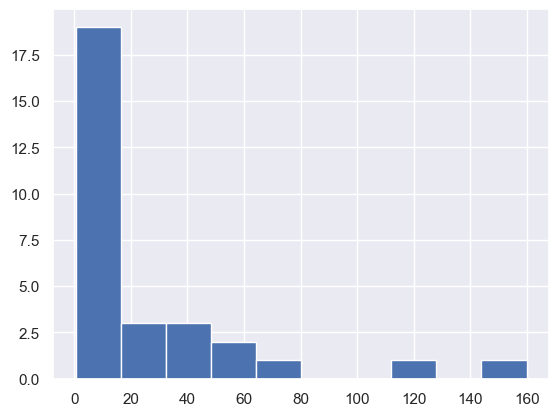

In [79]:
etc_snr.mean_snr_per_pixel.hist()

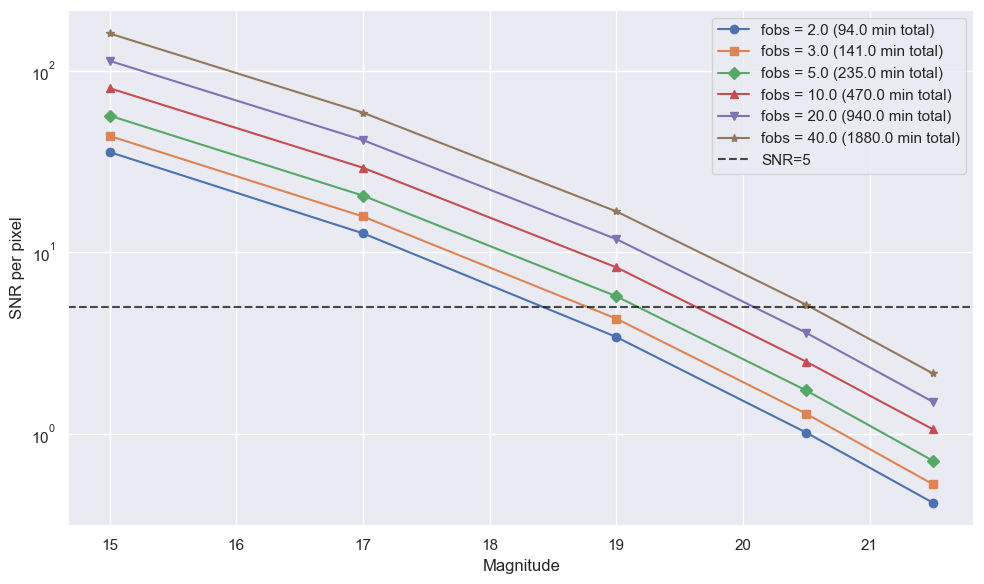

In [ ]:
plt.figure(figsize=(10, 6))

markers = ['o', 's', 'D', '^', 'v', '*']

for i, fob in enumerate(fobs):

    data = etc_snr[etc_snr['fobs'] == fob]

    plt.plot(data['mag'], data['mean_snr_per_pixel'], marker=markers[i], 
             label=f'fobs = {fob} ({fob * texp.value} min total)'
             )

    for snr in data['mean_snr_per_pixel']:
        if snr < 0.0:
            print(snr)

plt.axhline(y=5, color='black', linestyle='--', alpha=0.7, label='SNR=5')

plt.yscale('log')

plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('SNR per pixel', fontsize=12)

plt.legend(loc='upper right')

plt.tight_layout()

# plt.savefig('./../SNR/SNR_vs_fobs_mag.png', dpi=400)

plt.show()

# SNR of the whole catalogue

In [4]:
cat = pandas_from_fits('/data2/home2/nguerrav/Catalogues/ByCycle_Final_Cat_fobs_qso_templates.fits')
cat.head()

,SWEEP_NAME,INDEX_SWEEP,BRICKNAME,OBJID,TYPE,RA,DEC,EBV,SN_MAX,PLXSIG,...,CLASSIFICATION,COMPLETENESS,PARALLAX,MAG_TYPE,CAL_MAG_ID_BLUE,CAL_MAG_ID_GREEN,CAL_MAG_ID_RED,RULESET,NAME,fobs
0,000m030-005m025,16955.0,0029m287,425.0,REX,2.854988,-28.867229,0.016329,70.079727,-99.000000,...,AGN,1.0,0.0,DECam_z_AB,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,Fixed_BG_NOISE_0p33hr_Rulesets,MgIIBlueDeep_2.855m28.8672,1.112188
1,000m030-005m025,21473.0,0029m287,5019.0,REX,2.995691,-28.635296,0.013518,93.950668,-99.000000,...,AGN,1.0,0.0,DECam_z_AB,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,Fixed_BG_NOISE_0p33hr_Rulesets,MgIIBlueDeep_2.9957m28.6353,1.272858
2,000m030-005m025,21547.0,0029m287,5097.0,PSF,2.998681,-28.695906,0.014227,111.909660,-99.000000,...,AGN,1.0,0.0,DECam_z_AB,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,Fixed_BG_NOISE_0p33hr_Rulesets,MgIIBlueDeep_2.9987m28.6959,1.252395
3,000m030-005m025,21765.0,0029m287,5323.0,SER,3.007118,-28.631196,0.013384,175.493042,-99.000000,...,AGN,1.0,0.0,DECam_z_AB,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,Fixed_BG_NOISE_0p33hr_Rulesets,MgIIBlueDeep_3.0071m28.6312,4.838731
4,000m030-005m025,24879.0,0029m287,8506.0,PSF,3.104241,-28.746363,0.013091,200.720352,0.052104,...,AGN,1.0,0.0,DECam_z_AB,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,Fixed_BG_NOISE_0p33hr_Rulesets,MgIIBlueDeep_3.1042m28.7464,7.592981


In [5]:
one_qso = cat.loc[cat['NAME'] == 'MgIIBlueDeep_3.8049m32.078']  # one random qso
one_qso

,SWEEP_NAME,INDEX_SWEEP,BRICKNAME,OBJID,TYPE,RA,DEC,EBV,SN_MAX,PLXSIG,...,CLASSIFICATION,COMPLETENESS,PARALLAX,MAG_TYPE,CAL_MAG_ID_BLUE,CAL_MAG_ID_GREEN,CAL_MAG_ID_RED,RULESET,NAME,fobs
2213,000m035-005m030,760543.0,0036m320,10680.0,EXP,3.804881,-32.07805,0.015332,89.455704,-99.0,...,AGN,1.0,0.0,DECam_z_AB,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,Fixed_BG_NOISE_0p33hr_Rulesets,MgIIBlueDeep_3.8049m32.078,5.010373


In [6]:
z_str = str(np.round(one_qso['REDSHIFT_ESTIMATE'].values[0], 4))
mag_str = str(np.round(one_qso['MAG'].values[0], 2))
target_name = one_qso['NAME'].values[0]
model_id = f'QSO_sim_ETC_z{z_str}_mag{mag_str}_{target_name}'
model_id

'QSO_sim_ETC_z7.1_mag17.87_MgIIBlueDeep_3.8049m32.078'

In [7]:
spectrum_name = model_id + '_LJ1.fits'
spectrum_name

'QSO_sim_ETC_z7.1_mag17.87_MgIIBlueDeep_3.8049m32.078_LJ1.fits'

In [8]:
spectrum = Table.read('/data2/home2/nguerrav/QSO_simpaqs/QSOs_full_cat_ETC_L1_output_with_fobs/' + spectrum_name)
spectrum

WAVE,FLUX,ERR_FLUX,QUAL,FLUX_NOSS,ERR_FLUX_NOSS
Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2),,erg / (Angstrom s cm2),erg / (Angstrom s cm2)
float32[33775],float32[33775],float32[33775],int32[33775],float32[33775],float32[33775]
3926.10 .. 6789.90,1.02965e-18 .. 9.22382e-18,2.97160e-17 .. 1.01429e-17,0 .. 0,5.41612e-17 .. 5.34011e-17,2.97160e-17 .. 1.01429e-17


## Re-sample with conserved flux

In [9]:
import spectres

In [10]:
etc_grid = np.load('/data2/home2/nguerrav/QSO_simpaqs/npy_files/etc_wavelength_grid.npy')
etc_grid

array([3926.0692846 , 3926.14850865, 3926.22773052, ..., 6789.7044487 ,
       6789.8050222 , 6789.90559126])

In [11]:
spectrum['WAVE'][0]

array([3926.1 , 3926.15, 3926.2 , ..., 6789.8 , 6789.85, 6789.9 ],
      dtype='>f4')

In [12]:
rebin_spec = spectres.spectres(etc_grid, spectrum['WAVE'][0], spectrum['FLUX'][0], spec_errs=spectrum['ERR_FLUX'][0])#, fill=False)
rebin_spec

/home/nguerrav/miniconda3/envs/etc_4fs/lib/python3.12/site-packages/spectres/spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(


(array([           nan, 1.98816653e-17, 2.54496928e-17, ...,
        2.18668114e-17, 1.34559101e-17,            nan]),
 array([           nan, 2.02534791e-17, 2.10528158e-17, ...,
        6.63331296e-18, 6.49976196e-18,            nan]))

In [13]:
for i in range(rebin_spec[0].shape[0] - 1):
    if np.isnan(rebin_spec[0][i]):
        rebin_spec[0][i] = rebin_spec[0][i+1]
        rebin_spec[1][i] = rebin_spec[1][i+1]

if np.isnan(rebin_spec[0][-1]):
    rebin_spec[0][-1] = rebin_spec[0][-2]
    rebin_spec[1][-1] = rebin_spec[1][-2]

In [14]:
rebin_spec

(array([1.98816653e-17, 1.98816653e-17, 2.54496928e-17, ...,
        2.18668114e-17, 1.34559101e-17, 1.34559101e-17]),
 array([2.02534791e-17, 2.02534791e-17, 2.10528158e-17, ...,
        6.63331296e-18, 6.49976196e-18, 6.49976196e-18]))

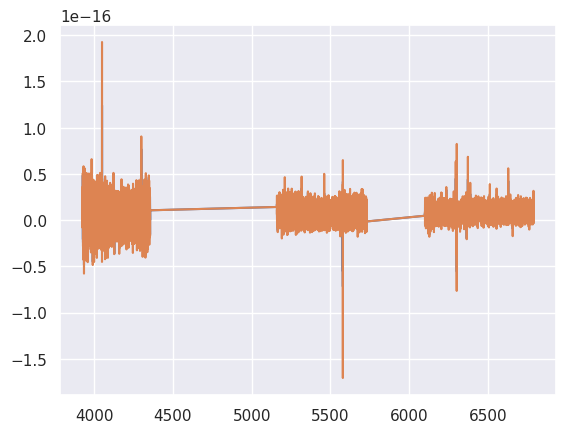

In [15]:
plt.plot(etc_grid, rebin_spec[0])
plt.plot(spectrum['WAVE'][0], spectrum['FLUX'][0])

In [26]:
spectrum['ERR_FLUX'].unit

Unit("erg / (Angstrom s cm2)")

In [27]:
spec_units = {
    'WAVE': u.AA, 
    'FLUX': u.erg / (u.AA * u.s * u.cm**2), 
    'ERR_FLUX': u.erg / (u.AA * u.s * u.cm**2)
}

In [63]:
rebinned_spectrum = Table()

rebinned_spectrum['WAVE'] = etc_grid.astype(np.float64)
rebinned_spectrum['FLUX'] = rebin_spec[0].astype(np.float64)
rebinned_spectrum['ERR_FLUX'] = rebin_spec[1].astype(np.float64)
for col_name, unit in spec_units.items():
    rebinned_spectrum[col_name].unit = unit

rebinned_spectrum

WAVE,FLUX,ERR_FLUX
Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2)
float64,float64,float64
3926.0692846030474,1.9881665299615157e-17,2.0253479100954835e-17
3926.148508646592,1.9881665299615157e-17,2.0253479100954835e-17
3926.227730516839,2.5449692817909317e-17,2.1052815801811465e-17
3926.3069502135795,5.638078985726556e-19,2.0741693971755758e-17
3926.3861677366026,-2.5175477596285975e-18,2.174430632372207e-17
3926.4653830856987,9.367131393073851e-18,2.2039865261916593e-17
3926.5445962606564,1.0485336328005016e-17,2.091920259134572e-17
3926.6238072612678,4.212177366498224e-18,2.115532456481083e-17


## SNR

In [64]:
rebinned_spectrum['SNR'] = rebinned_spectrum['FLUX'].value / rebinned_spectrum['ERR_FLUX'].value
rebinned_spectrum

WAVE,FLUX,ERR_FLUX,SNR
Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2),
float64,float64,float64,float64
3926.0692846030474,1.9881665299615157e-17,2.0253479100954835e-17,0.9816419786701165
3926.148508646592,1.9881665299615157e-17,2.0253479100954835e-17,0.9816419786701165
3926.227730516839,2.5449692817909317e-17,2.1052815801811465e-17,1.208849830706234
3926.3069502135795,5.638078985726556e-19,2.0741693971755758e-17,0.027182345826739146
3926.3861677366026,-2.5175477596285975e-18,2.174430632372207e-17,-0.11577963086741769
3926.4653830856987,9.367131393073851e-18,2.2039865261916593e-17,0.4250085597963988
3926.5445962606564,1.0485336328005016e-17,2.091920259134572e-17,0.5012302109614256
3926.6238072612678,4.212177366498224e-18,2.115532456481083e-17,0.19910719656386844


In [65]:
wav_ranges = [
    rebinned_spectrum['WAVE'] < 4500,
    (rebinned_spectrum['WAVE'] >= 4500) & (rebinned_spectrum['WAVE'] < 6000),
    rebinned_spectrum['WAVE'] >= 6000
]
arms = ['blue', 'green', 'red']

rebinned_spectrum['arm'] = np.select(wav_ranges, arms, default='unknown')
rebinned_spectrum

WAVE,FLUX,ERR_FLUX,SNR,arm
Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2),,
float64,float64,float64,float64,str7
3926.0692846030474,1.9881665299615157e-17,2.0253479100954835e-17,0.9816419786701165,blue
3926.148508646592,1.9881665299615157e-17,2.0253479100954835e-17,0.9816419786701165,blue
3926.227730516839,2.5449692817909317e-17,2.1052815801811465e-17,1.208849830706234,blue
3926.3069502135795,5.638078985726556e-19,2.0741693971755758e-17,0.027182345826739146,blue
3926.3861677366026,-2.5175477596285975e-18,2.174430632372207e-17,-0.11577963086741769,blue
3926.4653830856987,9.367131393073851e-18,2.2039865261916593e-17,0.4250085597963988,blue
3926.5445962606564,1.0485336328005016e-17,2.091920259134572e-17,0.5012302109614256,blue
3926.6238072612678,4.212177366498224e-18,2.115532456481083e-17,0.19910719656386844,blue


In [69]:
rebinned_spectrum['SNR'][rebinned_spectrum['arm']=='blue'].value

array([0.98164198, 0.98164198, 1.20884983, ..., 0.46381077, 0.8192593 ,
       0.57786177])